In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import os
import cv2
import string
import numpy as np

In [3]:
# Initialize main values
symbols = string.ascii_lowercase + "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)
img_shape = (50, 200, 1)

In [4]:
def create_model():
    img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp3)
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(256, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='softmax')(drop)

        outs.append(res)
    
    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    return model

In [21]:
def preprocess_data():
    n_samples = len(os.listdir('samples/samples'))
    X = np.zeros((n_samples, 50, 200, 1)) #1070*50*200
    y = np.zeros((5, n_samples, num_symbols)) #5*1070*36

    for i, pic in enumerate(os.listdir('samples/samples')):
        # Read image as grayscale
        img = cv2.imread(os.path.join('samples/samples', pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]
        if len(pic_target) < 6:
            # Scale and reshape image
            img = img / 255.0
            img = np.reshape(img, (50, 200, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((5, num_symbols))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs
    
    # Return final data
    return X, y

In [22]:
X, y = preprocess_data()
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]

In [23]:
model = create_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 200, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 50, 200, 32)  320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 25, 100, 32)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 25, 100, 64)  18496       max_pooling2d[0][0]              
_______________________________________________________________________________________

In [24]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [26]:
# Train the model
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], 
                 batch_size=32, epochs=20, verbose=1, 
                 validation_split=0.2, callbacks=[es])

Epoch 1/20
25/25 [==============================] - 13s 505ms/step - loss: 0.5503 - dense_1_loss: 0.0333 - dense_3_loss: 0.0678 - dense_5_loss: 0.1133 - dense_7_loss: 0.1578 - dense_9_loss: 0.1781 - dense_1_accuracy: 0.9936 - dense_3_accuracy: 0.9704 - dense_5_accuracy: 0.9601 - dense_7_accuracy: 0.9575 - dense_9_accuracy: 0.9433 - val_loss: 9.1671 - val_dense_1_loss: 5.5658 - val_dense_3_loss: 0.6723 - val_dense_5_loss: 0.9258 - val_dense_7_loss: 1.0875 - val_dense_9_loss: 0.9157 - val_dense_1_accuracy: 0.0258 - val_dense_3_accuracy: 0.8866 - val_dense_5_accuracy: 0.8093 - val_dense_7_accuracy: 0.7990 - val_dense_9_accuracy: 0.8608
Epoch 2/20
25/25 [==============================] - 13s 505ms/step - loss: 0.5201 - dense_1_loss: 0.0254 - dense_3_loss: 0.0565 - dense_5_loss: 0.0958 - dense_7_loss: 0.1611 - dense_9_loss: 0.1812 - dense_1_accuracy: 0.9871 - dense_3_accuracy: 0.9807 - dense_5_accuracy: 0.9678 - dense_7_accuracy: 0.9459 - dense_9_accuracy: 0.9317 - val_loss: 8.8993 - val_de

In [27]:
# Evaluate the model on the test set
score = model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]], verbose=1)
print('Test loss and accuracy:', score)

4/4 [==============================] - 0s 64ms/step - loss: 29.8298 - dense_1_loss: 27.1411 - dense_3_loss: 0.5180 - dense_5_loss: 0.8432 - dense_7_loss: 0.9294 - dense_9_loss: 0.3981 - dense_1_accuracy: 0.0000e+00 - dense_3_accuracy: 0.8400 - dense_5_accuracy: 0.7500 - dense_7_accuracy: 0.7600 - dense_9_accuracy: 0.9100
Test loss and accuracy: [29.829811096191406, 27.1411190032959, 0.518017053604126, 0.8432175517082214, 0.929373025894165, 0.3980869650840759, 0.0, 0.8399999737739563, 0.75, 0.7599999904632568, 0.9100000262260437]


In [28]:
# Define function to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0
    else:
        print("Image not detected")
        return None
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, num_symbols))
    captcha = ""
    for i in range(5):
        captcha += symbols[np.argmax(ans[i])]
    return captcha

In [29]:
import matplotlib.pyplot as plt

filepath = "captha_predict/predict.png"

def plot_predicted_sample(filepath):
    # Predict captcha
    captcha = predict(filepath)

    # Load image
    img = cv2.imread(filepath)

    # Plot image and predicted captcha
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.set_title(f"Predicted Captcha: {captcha}")
    plt.show()

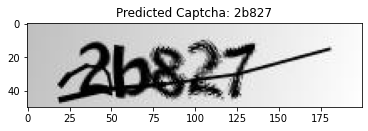

In [31]:
plot_predicted_sample("captha_predict/predict.png")